In [2]:
import os
os.chdir(r"C:\Users\ashto\DAPPEr-main") #change directory to dapper-main folder
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

Current directory: C:\Users\ashto\DAPPEr-main


In [ ]:
from src import *
from src.UDIP_Lib import *
import src.fitting.fit as R_fitting
import src.UDIP_Lib.UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
from src.RockSat_json.RockSat_json import import_data
import numpy as np
from scipy import signal
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [5]:
#fitting and helper functions.... fit.py and RockSat fitting functions might be messed up, I dont want to mess them up more
#so i will leave these here for now until fixed
def gen_fit(x_raw,y_raw):
    x,y = data_processing(x_raw,y_raw)
    g = [2, 2, 2, -14, 80, 5*(10**10), 700 ]    #intial guess
    b = [
        (-3,  -3, 2, -np.inf, -np.inf, 0     , 0    ),
        ( 3,   3, 5, np.inf,  np.inf, np.inf, 5000 )
        ] #bounds
    popt, pcov = optimize.curve_fit(model,x,y,g,bounds=b)
    max_1 = np.max(x)
    min_1 = np.min(x)
    t = np.linspace(min_1,max_1,num=1000)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

def model(V, Vf, V0, VP,  b, m1, ne, te):
    I = np.zeros(len(V))
    I[V <= Vf] = lin(V[V <= Vf], m1) - lin(Vf, m1) + b
    Vtrans = (V > Vf) & (V < VP)
    I[Vtrans] = exp(V[Vtrans], ne, te, VP) + b
    I[V >  VP] = sqrt(V[V >  VP], ne, te, V0) - sqrt(VP, ne, te, V0) + b
    return I

def lin(x, m):#linear--full model square root
    return m * x

def exp(x, ne, te, V1):
    q_e = 1.602e-19  # Electron charge [C]
    K_b = 1.381e-23  # Boltzmann constant [J/K]
    m_e = 9.109e-31  # Electron mass [kg]
    R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
    L = 3.25 * 2.54  # Length of probe [cm]
    A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
    I0 = ne * q_e * np.sqrt(K_b * te/ (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
    k = q_e / (K_b * te)
    return I0 * np.exp(k * (x - V1))

def sqrt(x,n,t,V0):# square root
    q_e = 1.602 * 10**-19 #C                charge of an electron
    K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10**-31 #kg               mass of an electron
    R = (3./16.) * 0.0254 #radius of probe
    L = (3.25) * 0.0254 #length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1.0 + k*(x - V0))

def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    x = np.nan_to_num(x_raw, nan=0.0)
    y = np.nan_to_num(y_raw, nan=0.0)
    x = x[6:]
    y = y[6:]
    return x,y

Loading altitude data from rockon

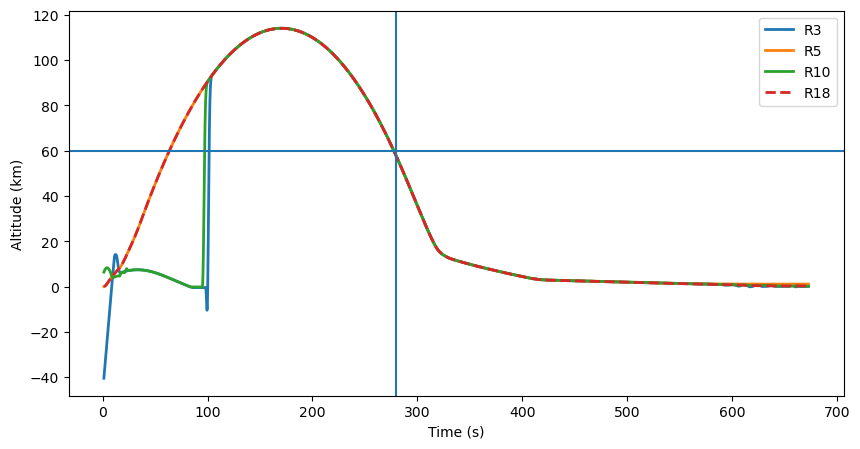

In [ ]:
times3 = []
times5 = []
times10 = []
times18 = []
altitudes3 = []
altitudes5 = []
altitudes10 = []
altitudes18 = []
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R5 POSDAT 06202024.txt", "r") as rockonData5: #R5
    next(rockonData5)  # Skip the header
    for line in rockonData5:
        parts = line.strip().split()
        times5.append(float(parts[1]))  # time values
        altitudes5.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R3 POSDAT 06202024.txt", "r") as rockonData3: #R3
    next(rockonData3)  # Skip the header
    for line in rockonData3:
        parts = line.strip().split()
        times3.append(float(parts[1]))  # time values
        altitudes3.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R10 POSDAT 06202024.txt", "r") as rockonData10: #R10
    next(rockonData10)  # Skip the header
    for line in rockonData10:
        parts = line.strip().split()
        times10.append(float(parts[1]))  # time values
        altitudes10.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R18 POSDAT 06202024.txt", "r") as rockonData18:
    next(rockonData18)  # Skip the header
    for line in rockonData18:
        parts = line.strip().split()
        times18.append(float(parts[1]))  # time values
        altitudes18.append(float(parts[9]) / 1000)  # altitude values in km
apogee3 = max(altitudes3)
apogee5 = max(altitudes5)
apogee10 = max(altitudes10)
apogee18 = max(altitudes18)
plt.figure(figsize=(10, 5))
plt.plot(times3, altitudes3, label= "R3", lw=2)
plt.plot(times5, altitudes5, label= "R5",lw=2) #i am using these values for data analysis
plt.plot(times10, altitudes10, label= "R10",lw=2)
plt.plot(times18, altitudes18, label= "R18",lw=2, ls='--')
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.legend()
plt.axvline(280)
plt.axhline(60)
plt.show()
#looks like R3,R10 messed up until t=100s, then they all make the same shape, 
# R5 and R18 look very similar, I am arbitrarily using R5 for analysis

Gathering IV data from sweeps, as well as temperature and density from fitting algorithm

In [7]:
packets = import_data('data/packets/UDIP_4_800s.json')
ne = np.array([])
Te = np.array([])
Imax = np.array([])
t_lin = np.array([])
starting_sweep = 173
stopping_sweep = 475 #170-475 are where we get good data roughly
st = packets['packets']['Full'][f'{starting_sweep}']['Start']
fin = packets['packets']['Full'][f'{stopping_sweep}']['Start']
step   = 1
for sweep in range(starting_sweep, stopping_sweep, step):
    c = 6
    V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:]) 
    I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
    #print(R_fitting.gen_fit(V, I)[2])
    Vfit, Ifit, popt, pcov = gen_fit(V, I)
    start = packets['packets']['Full'][f'{sweep}']['Start']
    stop  = packets['packets']['Full'][f'{sweep}']['Stop']
    t_lin = np.append(t_lin, (start + stop)/2/1000 - 57)
    ne = np.append(ne,popt[5]) #RockSat fit.gen_fit uses different popt indices as of now (popt[5] is temp, rather than density as seen here)
    Te = np.append(Te,popt[6])

    #For the bad values, cut IV to get just the top branch of it, hopefully yields better temperatures
    if(Te[-1] >= 2000):
        FirstFitTe = Te[-1]
        midpoint = len(V) // 2  # Find the middle of the sweep
        V_new = V[midpoint:]  # Take only the second half
        I_new = I[midpoint:]
        Vfit, Ifit, popt, pcov = gen_fit(V_new, I_new)

        #overwrite the Te and ne values with the new fit results
        Te[-1] = popt[6]
        if Te[-1] >= 2000:
            print(f"Warning: Sweep {sweep} still has Te >= 2000 (Te = {Te[-1]}) after second fit, went from {FirstFitTe} -> {Te[-1]}")
        ne[-1] = popt[5]

    Imax = np.append(Imax, np.max(I))


C:\Users\ashto\AppData\Local\Temp\ipykernel_19348\776693160.py:48: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))


# Temp & Density vs Altitude Ascending

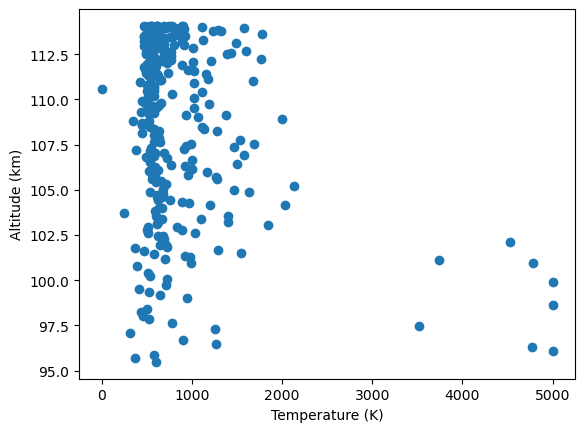

In [ ]:
altitude_function = interp1d(times5, altitudes5) 
interpolated_altitudes = altitude_function(t_lin) # Make altitude array based on time values from IV data
#plt.xlim(0,1000)
plt.scatter(Te, interpolated_altitudes) # this is both ascending and descending, want to separate
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude (km)")



apogee_value = np.where(interpolated_altitudes == apogee5)[0][0] #cutting list at apogee to find temperatures going up


# Temp & Density vs Altitude Descending

Text(0, 0.5, 'Altitude (km)')

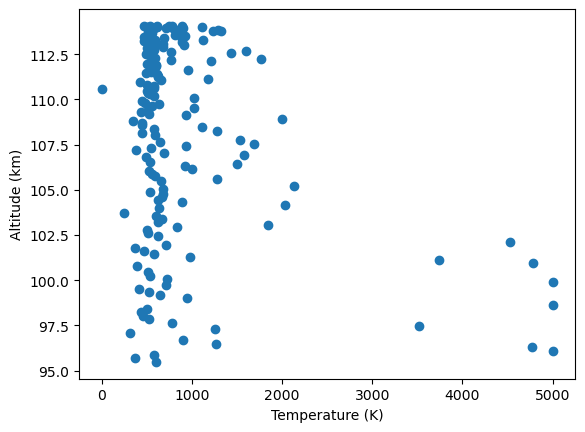

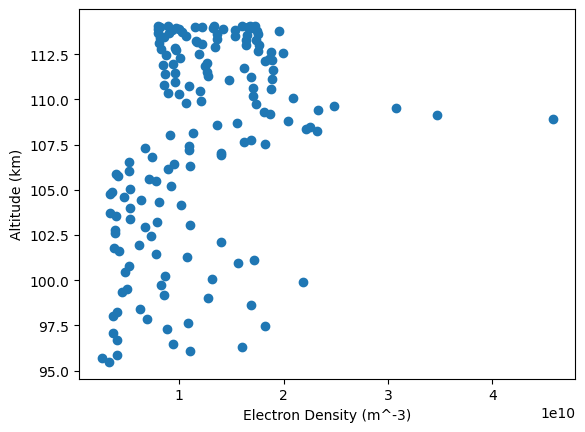

In [9]:
plt.figure()
plt.scatter(Te[apogee_value + 1:], interpolated_altitudes[apogee_value + 1:])
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude (km)")

plt.figure()
plt.scatter(ne[apogee_value + 1:], interpolated_altitudes[apogee_value + 1:])
plt.xlabel("Electron Density (m^-3)")
plt.ylabel("Altitude (km)")

# making stacked plots

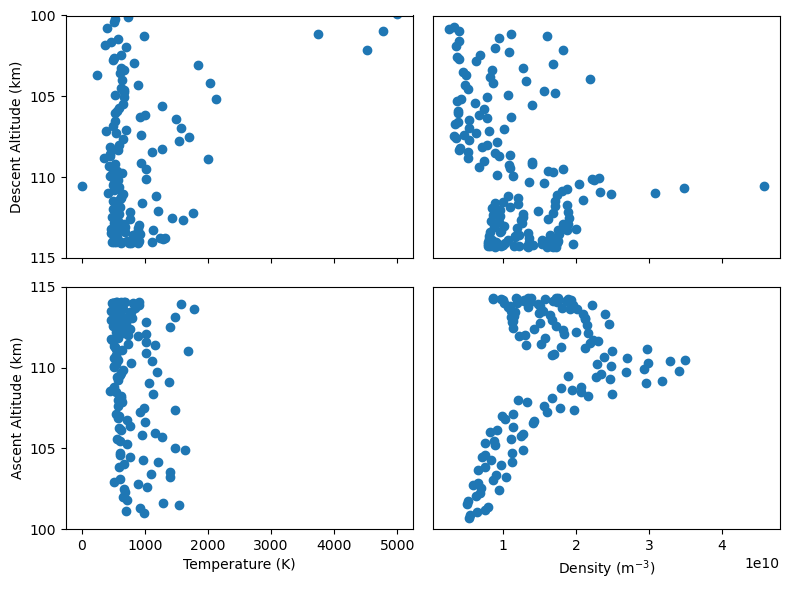

In [10]:
from matplotlib.ticker import MultipleLocator

fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(8, 6))

#left side is temperature
axes[1, 0].scatter(Te[:apogee_value], interpolated_altitudes[:apogee_value], label='Ascending') #[1,0] is bottom left
axes[0, 0].scatter(Te[apogee_value + 1:], interpolated_altitudes[apogee_value + 1:], label='Descending') #[0,0] top left

axes[1, 0].set_xlabel('Temperature (K)')
axes[1, 0].set_ylabel('Ascent Altitude (km)')
axes[0, 0].set_ylabel('Descent Altitude (km)')

#right density
axes[1, 1].scatter(ne[:apogee_value], interpolated_altitudes[:apogee_value], label='Ascending') #[1,1] bottom right
axes[0, 1].scatter(ne[apogee_value + 1:], interpolated_altitudes[apogee_value + 1:], label='Descending')#[0,1] top right

axes[1, 1].set_xlabel(r'Density (m$^{-3})$')

for ax in [axes[0, 1], axes[1, 1]]: #Remove y-axis labels and ticks from right-side plots
    ax.set_ylabel("")  
    ax.yaxis.set_tick_params(left=False, labelleft=False)

#tickmarks every 5 km to make it look neater
y_min, y_max = 100, 115
for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(MultipleLocator(5)) #tickmark every 5

axes[0, 0].invert_yaxis()
axes[0, 1].invert_yaxis()
plt.tight_layout()
plt.show()